# Detecting stops

<img align="right" src="https://movingpandas.github.io/movingpandas/assets/img/movingpandas.png">

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/movingpandas/movingpandas-examples/main?filepath=1-tutorials/8-detecting-stops.ipynb)
[![IPYNB](https://img.shields.io/badge/view-ipynb-hotpink)](https://github.com/movingpandas/movingpandas-examples/blob/main/1-tutorials/8-detecting-stops.ipynb)
[![HTML](https://img.shields.io/badge/view-html-green)](https://movingpandas.github.io/movingpandas-website/1-tutorials/8-detecting-stops.html)

There are no definitive answers when it comes to detecting / extracting stops from movement trajectories. Due to tracking inaccuracies, movement speed rarely goes to true zero. GPS tracks, for example, tend to keep moving around the object's stop location.

Suitable stop definitions are also highly application dependent. For example, an application may be interested in analyzing trip purposes. To do so, analysts would be interested in stops that are longer than, for example, 5 minutes and may try to infer the purpose of the stop from the stop location and time. Shorter stops, such as delays at traffic lights, however would not be relevant for this appication.

In the MovingPandas TrajectoryStopDetector implementation, a stop is detected if the movement stays within an area of specified size for at least the specified duration.

In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))

mpd.show_versions()


MovingPandas 0.17.2

SYSTEM INFO
-----------
python     : 3.9.18 (main, Sep 11 2023, 08:38:23)  [Clang 14.0.6 ]
executable : /opt/anaconda3/bin/python
machine    : macOS-10.16-x86_64-i386-64bit

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.4
GDAL data dir: /opt/anaconda3/lib/python3.9/site-packages/fiona/gdal_data
PROJ       : 9.2.1
PROJ data dir: /opt/anaconda3/lib/python3.9/site-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.13.2
pandas     : 2.1.4
fiona      : 1.9.4.post1
numpy      : 1.24.3
shapely    : 2.0.1
rtree      : 1.0.1
pyproj     : 3.6.0
matplotlib : 3.8.4
mapclassify: None
geopy      : 2.4.1
holoviews  : 1.18.3
hvplot     : 0.10.0
geoviews   : 1.12.0
stonesoup  : None


In [6]:
gdf = read_file('./geolife_small.gpkg')
tc = mpd.TrajectoryCollection(gdf, 'trajectory_id', t='t')

## Stop detection with a single Trajectory

In [7]:
my_traj = tc.trajectories[0]
my_traj

Trajectory 1 (2008-12-11 04:42:14 to 2008-12-11 05:15:46) | Size: 466 | Length: 6207.0m
Bounds: (116.385602, 39.862378, 116.393553, 39.898723)
LINESTRING (116.391305 39.898573, 116.391317 39.898617, 116.390928 39.898613, 116.390833 39.898635, 

In [8]:
traj_plot = my_traj.hvplot(title='Trajectory {}'.format(my_traj.id), line_width=7.0, tiles='CartoLight', color='slategray') 
traj_plot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

In [9]:
detector = mpd.TrajectoryStopDetector(my_traj)

### Stop duration

In [10]:
%%time
stop_time_ranges = detector.get_stop_time_ranges(min_duration=timedelta(seconds=60), max_diameter=100)

CPU times: user 138 ms, sys: 4.64 ms, total: 143 ms
Wall time: 141 ms


In [11]:
for x in stop_time_ranges: 
    print(x)

Traj 1: 2008-12-11 04:42:14 - 2008-12-11 04:43:32 (duration: 0 days 00:01:18)
Traj 1: 2008-12-11 04:43:52 - 2008-12-11 04:47:38 (duration: 0 days 00:03:46)
Traj 1: 2008-12-11 04:50:06 - 2008-12-11 04:51:23 (duration: 0 days 00:01:17)
Traj 1: 2008-12-11 04:54:50 - 2008-12-11 04:55:55 (duration: 0 days 00:01:05)
Traj 1: 2008-12-11 05:02:03 - 2008-12-11 05:06:34 (duration: 0 days 00:04:31)
Traj 1: 2008-12-11 05:07:19 - 2008-12-11 05:08:31 (duration: 0 days 00:01:12)
Traj 1: 2008-12-11 05:11:17 - 2008-12-11 05:13:38 (duration: 0 days 00:02:21)
Traj 1: 2008-12-11 05:13:51 - 2008-12-11 05:15:46 (duration: 0 days 00:01:55)


### Stop points

In [12]:
%%time
stop_points = detector.get_stop_points(min_duration=timedelta(seconds=60), max_diameter=100)

CPU times: user 180 ms, sys: 2.98 ms, total: 183 ms
Wall time: 181 ms


In [13]:
stop_points

,geometry,start_time,end_time,traj_id,duration_s
stop_id,,,,,
1_2008-12-11 04:42:14,POINT (116.39112 39.89861),2008-12-11 04:42:14,2008-12-11 04:43:32,1,78.0
1_2008-12-11 04:43:52,POINT (116.39071 39.89837),2008-12-11 04:43:52,2008-12-11 04:47:38,1,226.0
1_2008-12-11 04:50:06,POINT (116.38932 39.88923),2008-12-11 04:50:06,2008-12-11 04:51:23,1,77.0
1_2008-12-11 04:54:50,POINT (116.39232 39.87849),2008-12-11 04:54:50,2008-12-11 04:55:55,1,65.0
1_2008-12-11 05:02:03,POINT (116.39293 39.86384),2008-12-11 05:02:03,2008-12-11 05:06:34,1,271.0
1_2008-12-11 05:07:19,POINT (116.39024 39.86383),2008-12-11 05:07:19,2008-12-11 05:08:31,1,72.0
1_2008-12-11 05:11:17,POINT (116.38596 39.86519),2008-12-11 05:11:17,2008-12-11 05:13:38,1,141.0
1_2008-12-11 05:13:51,POINT (116.38603 39.86538),2008-12-11 05:13:51,2008-12-11 05:15:46,1,115.0


In [14]:
stop_point_plot = traj_plot * stop_points.hvplot(geo=True, size='duration_s', color='deeppink')
stop_point_plot

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Path.I    :Path   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.II :Points   [Longitude,Latitude]   (duration_s)

### Stop segments

In [15]:
%%time
stops = detector.get_stop_segments(min_duration=timedelta(seconds=60), max_diameter=100)

CPU times: user 185 ms, sys: 3.04 ms, total: 188 ms
Wall time: 187 ms


In [16]:
stops

TrajectoryCollection with 8 trajectories

In [17]:
stop_segment_plot = stop_point_plot * stops.hvplot(line_width=7.0, tiles=None, color='orange') 
stop_segment_plot

:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Path.I      :Path   [Longitude,Latitude]
   .Points.I    :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.II   :Points   [Longitude,Latitude]   (duration_s)
   .Path.II     :Path   [Longitude,Latitude]
   .Path.III    :Path   [Longitude,Latitude]
   .Path.IV     :Path   [Longitude,Latitude]
   .Path.V      :Path   [Longitude,Latitude]
   .Path.VI     :Path   [Longitude,Latitude]
   .Path.VII    :Path   [Longitude,Latitude]
   .Path.VIII   :Path   [Longitude,Latitude]
   .Path.IX     :Path   [Longitude,Latitude]
   .Points.III  :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.IV   :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.V    :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.VI   :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.VII  :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.VIII :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.IX   :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.X    :Points   [Longitude,Latitude]   (triangle_angle)

### Split at stops

In [18]:
%%time
split = mpd.StopSplitter(my_traj).split(min_duration=timedelta(seconds=60), max_diameter=100)

CPU times: user 231 ms, sys: 4.55 ms, total: 235 ms
Wall time: 350 ms


In [19]:
split

TrajectoryCollection with 7 trajectories

In [20]:
split.to_traj_gdf()

,trajectory_id,start_t,end_t,geometry,length,direction
0,1_2008-12-11 04:43:32,2008-12-11 04:43:32,2008-12-11 04:43:52,"LINESTRING (116.39083 39.89863, 116.38941 39.8...",264.335588,192.205758
1,1_2008-12-11 04:47:38,2008-12-11 04:47:38,2008-12-11 04:50:06,"LINESTRING (116.39030 39.89843, 116.39019 39.8...",1080.164181,186.476476
2,1_2008-12-11 04:51:23,2008-12-11 04:51:23,2008-12-11 04:54:50,"LINESTRING (116.39000 39.88924, 116.39010 39.8...",1378.618493,169.324962
3,1_2008-12-11 04:55:55,2008-12-11 04:55:55,2008-12-11 05:02:03,"LINESTRING (116.39183 39.87814, 116.39174 39.8...",1909.066931,176.111541
4,1_2008-12-11 05:06:34,2008-12-11 05:06:34,2008-12-11 05:07:19,"LINESTRING (116.39251 39.86398, 116.39239 39.8...",145.517971,262.952795
5,1_2008-12-11 05:08:31,2008-12-11 05:08:31,2008-12-11 05:11:17,"LINESTRING (116.38974 39.86382, 116.38967 39.8...",439.686682,300.319621
6,1_2008-12-11 05:13:38,2008-12-11 05:13:38,2008-12-11 05:13:51,"LINESTRING (116.38587 39.86544, 116.38584 39.8...",16.921893,349.846256


In [21]:
stop_segment_plot + split.hvplot(title='Trajectory {} split at stops'.format(my_traj.id), line_width=7.0, tiles='CartoLight')

:Layout
   .Overlay.I  :Overlay
      .WMTS.I      :WMTS   [Longitude,Latitude]
      .Path.I      :Path   [Longitude,Latitude]
      .Points.I    :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.II   :Points   [Longitude,Latitude]   (duration_s)
      .Path.II     :Path   [Longitude,Latitude]
      .Path.III    :Path   [Longitude,Latitude]
      .Path.IV     :Path   [Longitude,Latitude]
      .Path.V      :Path   [Longitude,Latitude]
      .Path.VI     :Path   [Longitude,Latitude]
      .Path.VII    :Path   [Longitude,Latitude]
      .Path.VIII   :Path   [Longitude,Latitude]
      .Path.IX     :Path   [Longitude,Latitude]
      .Points.III  :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.IV   :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.V    :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.VI   :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.VII  :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.VIII :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.IX   :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.X    :Points   [Longitude,Latitude]   (triangle_angle)
   .Overlay.II :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Path.I     :Path   [Longitude,Latitude]
      .Path.II    :Path   [Longitude,Latitude]
      .Path.III   :Path   [Longitude,Latitude]
      .Path.IV    :Path   [Longitude,Latitude]
      .Path.V     :Path   [Longitude,Latitude]
      .Path.VI    :Path   [Longitude,Latitude]
      .Path.VII   :Path   [Longitude,Latitude]
      .Points.I   :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.II  :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.III :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.IV  :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.V   :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.VI  :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.VII :Points   [Longitude,Latitude]   (triangle_angle)

## Stop Detection for TrajectoryCollections

The process is the same as for individual trajectories.

In [22]:
%%time
detector = mpd.TrajectoryStopDetector(tc)
stop_points = detector.get_stop_points(min_duration=timedelta(seconds=120), max_diameter=100)
len(stop_points)

CPU times: user 2 s, sys: 8.88 ms, total: 2.01 s
Wall time: 2.1 s


31

<Axes: >

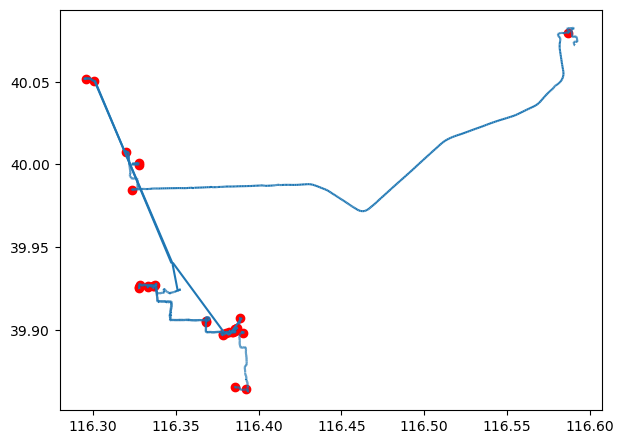

In [23]:
ax = tc.plot(figsize=(7,7))
stop_points.plot(ax=ax, color='red')